# Bank Marketing UCI Modeling

Notes
* Scaler for svc
* Different optuna trials, samplers

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import optuna
import shap

### Import data

In [41]:
def read_data(path: str, files: list):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file, sep=','))
    return dataframes


path = '../data/'
files = ['bank_data.csv']
bank_data = read_data(path, files)[0]
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


In [42]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

### Feature Engineering

* Imputing (removing unknown)
* Binning, not only age
* Encoding (target, etc)
* Outliers
* Log transformations


* Drop 'duration' feature not to use leaks

In [43]:
bank_data.drop(columns='duration', inplace=True)

* Cutting age to bins

In [44]:
def make_bins(data, feature, label_names, cut_points):
    data[feature] = pd.cut(data[feature], cut_points, labels=label_names)

    
labels = [24, 38, 53, 68]
cut_pts = [16, 30, 45, 60, 98]
make_bins(bank_data, 'age', labels, cut_pts)
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,53,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,53,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,38,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,38,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,53,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Dealing with missing values ('unknown')

In [45]:
bank_data[bank_data == 'unknown'].count()

age                  0
job                330
marital             80
education         1730
default           8596
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
ts_month             0
dtype: int64

In [51]:
bank_data.job.value_counts()

admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [38]:
def encode_categorical(features, data):
    for feature in features:
        data = pd.concat([data.drop(feature, axis=1), pd.get_dummies(data[feature], prefix=feature, prefix_sep='_',
                                                                     drop_first=True, dummy_na=False)], axis=1)
    display(data.sample(5))
    return data
        
        
cat_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age', 'default', 'housing', 'loan', 'day_of_week']
bank_data = encode_categorical(cat_features, bank_data)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month,...,default_1,default_unknown,housing_1,housing_unknown,loan_1,loan_unknown,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
22380,3,999,0,1.4,93.444,-36.1,4.964,5228.1,0,3,...,0,0,1,0,0,0,0,0,0,0
3498,8,999,0,1.1,93.994,-36.4,4.860,5191.0,0,0,...,0,0,0,0,1,0,0,1,0,0
34329,1,999,1,-1.8,92.893,-46.2,1.266,5099.1,0,9,...,0,0,1,0,0,0,0,1,0,0
40430,1,6,5,-1.7,94.027,-38.3,0.904,4991.6,1,22,...,0,0,0,0,0,0,1,0,0,0
13501,1,999,0,1.4,93.918,-42.7,4.963,5228.1,0,2,...,0,0,1,0,0,0,0,1,0,0


### Model Selection & HPO

* Train/valid/test split: I'll split data according to 'ts_month' feature
* Train: 0 - 23 months
* Valid: 24 month
* Test: 25 month

In [12]:
class TimeSeriesCycle:
    def __init__(self,
                 data: pd.DataFrame,
                 models_with_params: dict,
                 metric: object,
                 start_border: int,
                 train_border: int,
                 valid_border: int,
                 test_border: int,
                 cv_step: int,
                 optuna_trials: int
                ):
        self.data = data
        self.models_with_params = models_with_params
        self.metric = metric
        self.start_border = start_border
        self.train_border = train_border
        self.valid_border = valid_border
        self.test_border = test_border    
        self.cv_step = cv_step
        self.optuna_trials = optuna_trials
        self.best_estimators = []
        self.final_estimator = None
        self.final_fitted_estimator = None
        self.shap_values = None
        
   
    def evaluate_model(self, model, params):
        def objective(trial):
            model.set_params(**params(trial))
            train_scores = []
            valid_scores = []
            for i in range(self.start_border + self.cv_step, self.train_border + 1, self.cv_step):
                X_train = self.data[self.data['ts_month'] < i].drop(columns=['y'])
                y_train = self.data[self.data['ts_month'] < i]['y']
                X_valid = self.data[self.data['ts_month'] == i].drop(columns=['y'])
                y_valid = self.data[self.data['ts_month'] == i]['y']

                model.fit(X_train, y_train)
                train_scores.append(self.metric(y_train, model.predict(X_train)))
                valid_scores.append(self.metric(y_valid, model.predict(X_valid)))
            print('Train scores:', train_scores)
            print('Mean train score:', np.mean(train_scores))
            return np.mean(valid_scores)
        
        
        start = time.time()
        study_name = 'study'
        study = optuna.create_study(study_name=study_name, direction='maximize', sampler=optuna.samplers.TPESampler())
        study.optimize(objective, n_trials=self.optuna_trials, show_progress_bar=True, gc_after_trial=True)
        end = time.time()
        
        print('Best score: {}'.format(study.best_value))
        print('Best params: {}'.format(study.best_params))
        print('Taken time: {}'.format(int(end - start)))
        
        self.best_estimators.append((model, study.best_params))
    
    
    def compare_models(self):
        for model, params in self.models_with_params.items():
            print('Hyperparameters tuning for', type(model).__name__)
            self.evaluate_model(model, params)
            print('Tuning completed for {}!'.format(type(model).__name__))

            
        X_train = self.data[self.data['ts_month'] <= self.train_border].drop(columns=['y'])
        y_train = self.data[self.data['ts_month'] <= self.train_border]['y']
        X_valid = self.data[self.data['ts_month'] == self.valid_border].drop(columns=['y'])
        y_valid = self.data[self.data['ts_month'] == self.valid_border]['y']
        
        valid_scores = []
        for model, params in self.best_estimators:
            model.set_params(**params)
            model.fit(X_train, y_train)
            
            train_score = self.metric(y_train, model.predict(X_train))
            valid_score = self.metric(y_valid, model.predict(X_valid))
            print('Train score for {} ='.format(type(model).__name__), train_score)
            print('Validation score for {} = '.format(type(model).__name__), valid_score)
            valid_scores.append(valid_score)
            
        self.final_estimator = self.best_estimators[np.argmax(valid_scores)]
    
    
    def get_predictions(self):
        start = time.time()
        
        model, params = self.final_estimator
        model.set_params(**params)
        print('Final model: ' + str(model))
        X = self.data[self.data['ts_month'] <= self.valid_border].drop(columns=['y'])
        y = self.data[self.data['ts_month'] <= self.valid_border]['y']
        print('Fitting...')
        model.fit(X, y)
        X_test = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        y_test = self.data[self.data['ts_month'] == self.test_border]['y']
        print('Test score for {} ='.format(type(model).__name__), self.metric(y_test, model.predict(X_test)))
        
        end = time.time()
        print('Took ' + str(int(end - start)) + ' seconds to get final predictions')
        self.final_fitted_estimator = model
    
    
    def explain_model(self, model, data='train'):
        explainer = shap.Explainer(model)
        if data == 'train':
            X = self.data[self.data['ts_month'] <= self.valid_border].sample(1000, random_state=10).drop(columns=['y'])
        else:
            X = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        self.shap_values = explainer(X)
        shap.summary_plot(self.shap_values, X)

In [28]:
def bank_metric(y_valid, y_pred):
    coeffs = np.array([100, -20, -5, 3])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    return np.dot(cm, coeffs)


log_reg_model = LogisticRegression()
def log_reg_params(trial):
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1, log=True),
       # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }
    return params


svm_model = SVC()
def svm_params(trial):
    params = {
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly', 'linear']),
        'C': trial.suggest_float("C", 0.1, 3.0, log=True),
        'gamma': trial.suggest_categorical('gamma', ['auto', 'scale']),
        'degree': trial.suggest_int("degree", 1, 3, log=True)
    }
    return params


xgb_model = xgb.XGBClassifier()
def xgb_params(trial):
    params = {
              'n_estimators': trial.suggest_int('n_estimators', 1, 150),
              'max_depth': trial.suggest_int('max_depth', 3, 12),
              'reg_alpha': trial.suggest_float('reg_alpha', 0, 4),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
              'gamma': trial.suggest_float('gamma', 0, 4),
              'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5, log=True),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
              'subsample': trial.suggest_float('subsample', 0.4, 0.9),
              'nthread': -1
              }
    return params

rf_model = RandomForestClassifier()
def rf_params(trial):
    params = {
             'bootstrap': trial.suggest_categorical('bootstrap', ['True', 'False']),
             'max_depth': trial.suggest_int('max_depth', 1, 20),
             'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
             'n_estimators': trial.suggest_int('n_estimators', 1, 300),
             'n_jobs': -1
             }
    return params

tsc = TimeSeriesCycle(data=bank_data,
                      models_with_params={#rf_model: rf_params,
                                          xgb_model: xgb_params
                                          #log_reg_model: log_reg_params,
                                          #svm_model: svm_params
                                          },
                      metric=bank_metric,
                      start_border=0,
                      train_border=23,
                      valid_border=24,
                      test_border=25,
                      cv_step=5,
                      optuna_trials=10 #20
                     )

In [29]:
tsc.compare_models()

[I 2022-11-18 09:21:51,617] A new study created in memory with name: study


Hyperparameters tuning for XGBClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Train scores: [50367, 79673, 96805, 140711]
Mean train score: 91889.0
[I 2022-11-18 09:21:58,054] Trial 0 finished with value: 4141.25 and parameters: {'n_estimators': 90, 'max_depth': 7, 'reg_alpha': 0.7399706771726331, 'reg_lambda': 1.26766478852271, 'min_child_weight': 1, 'gamma': 0.8466689950793489, 'learning_rate': 0.08216432006060129, 'colsample_bytree': 0.6637151525105274, 'subsample': 0.6395246827365393}. Best is trial 0 with value: 4141.25.
Train scores: [50503, 78001, 96197, 135823]
Mean train score: 90131.0
[I 2022-11-18 09:22:06,080] Trial 1 finished with value: 4461.25 and parameters: {'n_estimators': 94, 'max_depth': 6, 'reg_alpha': 2.4837427147768194, 'reg_lambda': 0.16195397622673213, 'min_child_weight': 0, 'gamma': 0.4937827456363979, 'learning_rate': 0.10774151861684159, 'colsample_bytree': 0.7319661626140175, 'subsample': 0.874393603260079}. Best is trial 1 with value: 4461.25.
Train scores: [50607, 64201, 71685, 112631]
Mean train score: 74781.0
[I 2022-11-18 09:22:

In [30]:
tsc.get_predictions()

Final model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5910183235020923, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=1.0288402047715173, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3362050095504938, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=147, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.11406984658092956, ...)
Fitting...
Test score for XGBClassifier = 5106
Took 1 seconds to get final predictions


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


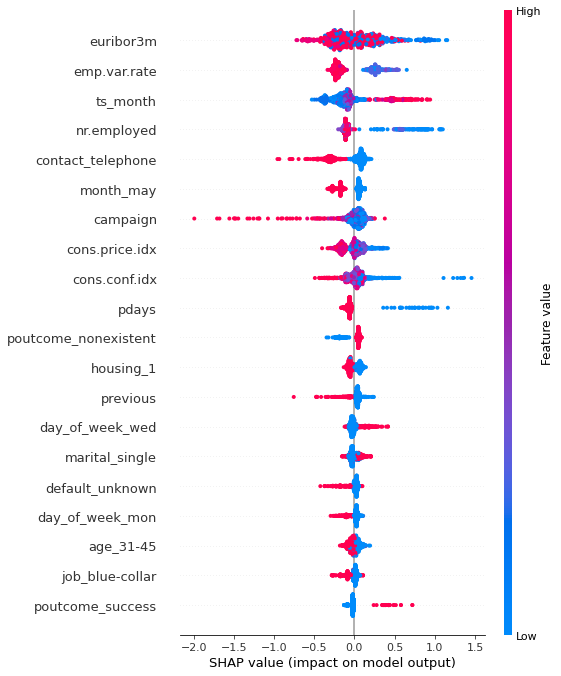

In [31]:
tsc.explain_model(tsc.final_fitted_estimator, data='train')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


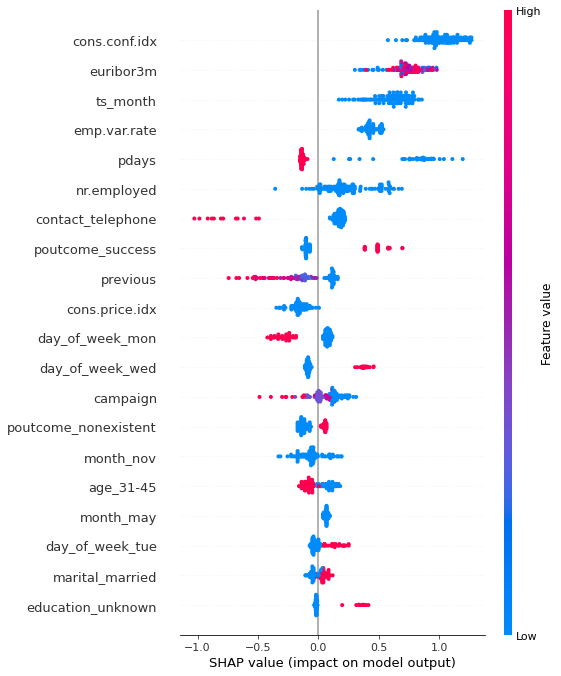

In [32]:
tsc.explain_model(tsc.final_fitted_estimator, data='test')

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
X = bank_data.drop(columns='y')
y = bank_data['y']

rf = RandomForestClassifier(n_estimators=500)

scoring = {'accuracy': 'accuracy', 'recall': 'recall'}
scores = cross_validate(rf, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                        return_train_score=True)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_accuracy',
 'test_recall',
 'train_accuracy',
 'train_recall']

In [23]:
print('Train accuracy: ', scores['train_accuracy'])
print('Valid accuracy: ', scores['test_accuracy'])
print('Train recall: ', scores['train_recall'])
print('Valid recall: ', scores['test_recall'])

Train accuracy:  [0.98849423 0.98907137 0.98825172 0.9887678  0.98761422]
Valid accuracy:  [0.88950947 0.88609593 0.89350334 0.88755313 0.89338191]
Train recall:  [0.90703314 0.91136853 0.90460792 0.90972784 0.8986796 ]
Valid recall:  [0.29418103 0.27292341 0.31142241 0.29202586 0.30280172]


### Final model quality check